<h3>주식 가격 예측</h3>

In [1]:
#https://github.com/kairess/stock_crypto_price_prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

import datetime

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/005930.KS_5y.csv')
data.dropna(axis=0)
data.head()
#데이터에 null값이 있으면 예측할수 없음

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-30,29700.0,30000.0,29680.0,30000.0,41.274914,10588400
1,2013-10-31,29960.0,30040.0,29300.0,29300.0,40.311840,12647050
2,2013-11-01,29800.0,30000.0,29360.0,30000.0,41.274914,11357700
3,2013-11-04,29840.0,30040.0,29780.0,29980.0,41.247398,10887800
4,2013-11-05,30040.0,30040.0,29440.0,29700.0,40.862167,8009300


In [3]:
#데이터 구성

high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [4]:
#윈도우 만들기
#최근 50일간 데이터를 보고 내일을 예측함

seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [5]:
#데이터 정규화
#첫번째 값 0 윈도우의 값을 정규화함
#10/01, 10/02라면 첫번째는 0, 두번째는 (02/01) -1

normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

In [6]:

row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1057, 50, 1), (117, 50, 1))

In [7]:
#모델정의

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear')) #다음날 하루
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [8]:
#학습

model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         batch_size = 10,
         epochs = 20)

Train on 1057 samples, validate on 117 samples
Epoch 1/20
1057/1057 [==============================] - 3s 3ms/step - loss: 0.0014 - val_loss: 5.5019e-04
Epoch 2/20
1057/1057 [==============================] - 3s 3ms/step - loss: 7.1030e-04 - val_loss: 5.2452e-04
Epoch 3/20
1057/1057 [==============================] - 3s 3ms/step - loss: 5.1051e-04 - val_loss: 3.4134e-04
Epoch 4/20
1057/1057 [==============================] - 3s 3ms/step - loss: 4.1785e-04 - val_loss: 2.6315e-04
Epoch 5/20
1057/1057 [==============================] - 3s 3ms/step - loss: 3.3190e-04 - val_loss: 1.5948e-04
Epoch 6/20
1057/1057 [==============================] - 3s 3ms/step - loss: 2.7597e-04 - val_loss: 1.4646e-04
Epoch 7/20
1057/1057 [==============================] - 3s 3ms/step - loss: 2.5311e-04 - val_loss: 2.2442e-04
Epoch 8/20
1057/1057 [==============================] - 3s 3ms/step - loss: 2.3370e-04 - val_loss: 1.4875e-04
Epoch 9/20
1057/1057 [==============================] - 3s 3ms/step - loss: 2

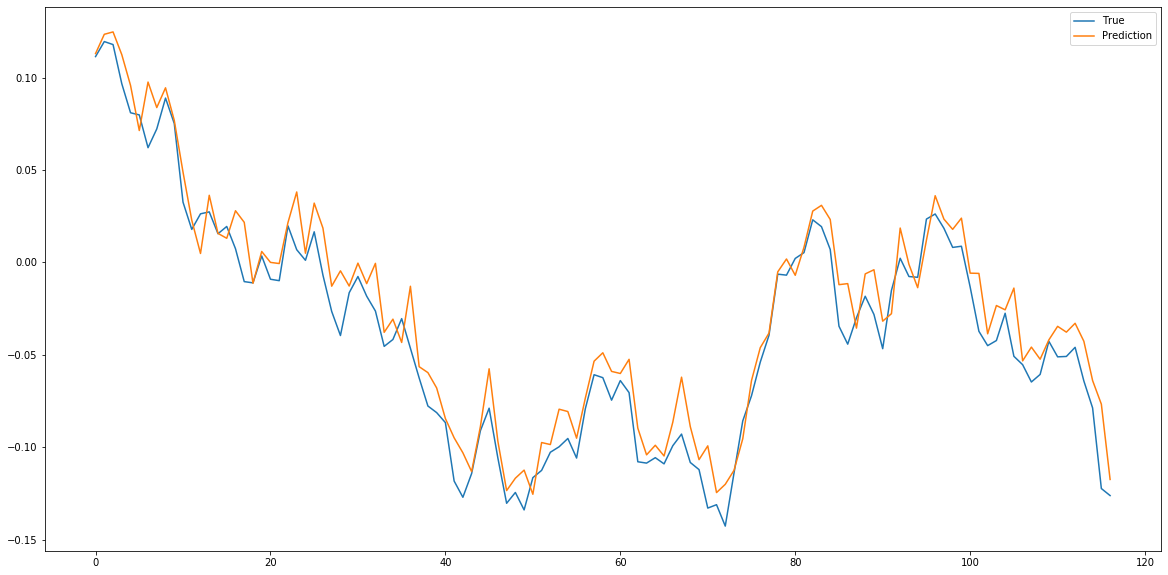

In [9]:
#예측

pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()